In [1]:
!pip3 install gdown
import pandas as pd
import numpy as np
import gdown
# https://drive.google.com/file/d/1JhMQl_ZKg7PQjB-I_I41ngH1fLgFPlz_/view?usp=drive_link
file_id = "1JhMQl_ZKg7PQjB-I_I41ngH1fLgFPlz_"
download_url = f"https://drive.google.com/uc?id={file_id}"

output = "data.csv"
gdown.download(download_url, output, quiet=False)
pd.set_option('display.max_columns', None)
df = pd.read_csv("data.csv", encoding='ISO-8859-1')

Downloading...
From (original): https://drive.google.com/uc?id=1JhMQl_ZKg7PQjB-I_I41ngH1fLgFPlz_
From (redirected): https://drive.google.com/uc?id=1JhMQl_ZKg7PQjB-I_I41ngH1fLgFPlz_&confirm=t&uuid=66028420-788a-43ac-bd59-51dc771f6389
To: /workspaces/Spotify_song_recomender/data.csv
100%|██████████| 42.7M/42.7M [00:01<00:00, 33.4MB/s]
/tmp/ipykernel_8809/1847640007.py:12: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding='ISO-8859-1')


In [2]:
df = pd.read_csv("data.csv", encoding='ISO-8859-1')
df.head()

/tmp/ipykernel_8809/1217874449.py:1: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding='ISO-8859-1')


,id,artists,available_markets,disc_number,duration_ms.x,explicit,href,is_local,name,popularity,preview_url,track_number,type.x,uri.x,album.album_type,album.artists,album.available_markets,album.href,album.id,album.images,album.name,album.release_date,album.release_date_precision,album.total_tracks,album.type,album.uri,album.external_urls.spotify,external_ids.isrc,external_urls.spotify,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type.y,uri.y,track_href,analysis_url,duration_ms.y,time_signature
0,000xQL6tZNLJzIrtIgxqSl,https://api.spotify.com/v1/artists/5ZsFI1h6hId...,"AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR...",1,188490,FALSE,https://api.spotify.com/v1/tracks/000xQL6tZNLJ...,FALSE,Still Got Time (feat. PARTYNEXTDOOR),63,https://p.scdn.co/mp3-preview/cc28d32b3c106428...,1,track,spotify:track:000xQL6tZNLJzIrtIgxqSl,single,https://api.spotify.com/v1/artists/5ZsFI1h6hId...,"AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR...",https://api.spotify.com/v1/albums/2kGUeTGnkLOY...,2kGUeTGnkLOYlinKRJe47G,"640, 300, 64, https://i.scdn.co/image/ab67616d...",Still Got Time (feat. PARTYNEXTDOOR),2017-03-23,day,1,album,spotify:album:2kGUeTGnkLOYlinKRJe47G,https://open.spotify.com/album/2kGUeTGnkLOYlin...,USRC11700675,https://open.spotify.com/track/000xQL6tZNLJzIr...,0.748,0.627,7.0,-6.029,1.0,0.0639,0.131000,0.000000,0.0852,0.524,120.963,audio_features,spotify:track:000xQL6tZNLJzIrtIgxqSl,https://api.spotify.com/v1/tracks/000xQL6tZNLJ...,https://api.spotify.com/v1/audio-analysis/000x...,188491.0,4.0
1,001UkMQHw4zXfFNdKpwXAF,https://api.spotify.com/v1/artists/0XKOBt59crn...,"AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR...",1,191053,FALSE,https://api.spotify.com/v1/tracks/001UkMQHw4zX...,FALSE,Brand New Man - with Luke Combs,68,https://p.scdn.co/mp3-preview/20f3865bebd50d0f...,1,track,spotify:track:001UkMQHw4zXfFNdKpwXAF,album,https://api.spotify.com/v1/artists/0XKOBt59crn...,"AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR...",https://api.spotify.com/v1/albums/0U3nI78LUpAw...,0U3nI78LUpAwprraUf7vAS,"640, 300, 64, https://i.scdn.co/image/ab67616d...",Reboot,2019-04-05,day,12,album,spotify:album:0U3nI78LUpAwprraUf7vAS,https://open.spotify.com/album/0U3nI78LUpAwprr...,USAN21800051,https://open.spotify.com/track/001UkMQHw4zXfFN...,0.573,0.846,7.0,-4.866,1.0,0.0344,0.003720,0.000079,0.2900,0.562,127.061,audio_features,spotify:track:001UkMQHw4zXfFNdKpwXAF,https://api.spotify.com/v1/tracks/001UkMQHw4zX...,https://api.spotify.com/v1/audio-analysis/001U...,191053.0,4.0
2,003FTlCpBTM4eSqYSWPv4H,https://api.spotify.com/v1/artists/3vAaWhdBR38...,"AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR...",1,233266,FALSE,https://api.spotify.com/v1/tracks/003FTlCpBTM4...,FALSE,"Swing, Swing",67,NaN,3,track,spotify:track:003FTlCpBTM4eSqYSWPv4H,album,https://api.spotify.com/v1/artists/3vAaWhdBR38...,"AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR...",https://api.spotify.com/v1/albums/0TvOeelcHQXY...,0TvOeelcHQXYgPcyQiLhyR,"640, 300, 64, https://i.scdn.co/image/ab67616d...",The All-American Rejects,2002-10-15,day,11,album,spotify:album:0TvOeelcHQXYgPcyQiLhyR,https://open.spotify.com/album/0TvOeelcHQXYgPc...,USDW10200529,https://open.spotify.com/track/003FTlCpBTM4eSq...,0.553,0.717,7.0,-5.857,1.0,0.0318,0.000065,0.128000,0.0385,0.318,127.947,audio_features,spotify:track:003FTlCpBTM4eSqYSWPv4H,https://api.spotify.com/v1/tracks/003FTlCpBTM4...,https://api.spotify.com/v1/audio-analysis/003F...,233267.0,4.0
3,003vvx7Niy0yvhvHt4a68B,https://api.spotify.com/v1/artists/0C0XlULifJt...,"AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR...",1,222973,FALSE,https://api.spotify.com/v1/tracks/003vvx7Niy0y...,FALSE,Mr. Brightside,80,NaN,2,track,spotify:track:003vvx7Niy0yvhvHt4a68B,album,https://api.spotify.com/v1/artists/0C0XlULifJt...,"AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR...",https://api.spotify.com/v1/albums/4piJq7R3gjUO...,4piJq7R3gjUOxnYs6lDCTg,"640, 300, 64, https://i.scdn.co/image/ab67616d...",Hot Fuss,2004,y

In [4]:
df.dropna(inplace=True)

In [5]:
a=df["artists"].head(1)
a

0    https://api.spotify.com/v1/artists/5ZsFI1h6hId...
Name: artists, dtype: object

In [6]:
def clean_artists_column(artist_string):
    if pd.isna(artist_string):
        return []

    items = [item.strip() for item in artist_string.split(",")]

    prefixes_to_remove = [
        "https://api.spotify.com/v1/artists/",
        "spotify:artist:",
        "https://open.spotify.com/artist/"
    ]

    cleaned_items = []
    for item in items:
        for prefix in prefixes_to_remove:
            if item.startswith(prefix):
                item = item.replace(prefix, "")
        cleaned_items.append(item)

    final_items = [item for item in cleaned_items if item.lower() != "artist"]
    seen = set()
    unique_items = []
    for item in final_items:
        if item not in seen:
            unique_items.append(item)
            seen.add(item)

    return unique_items
df['updated_artists'] = df['artists'].apply(clean_artists_column)

In [7]:
df['available_markets'] = df['available_markets'].str.split(', ')
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
market_dummies = pd.DataFrame(mlb.fit_transform(df['available_markets']),
                              columns=mlb.classes_,
                              index=df.index)
df = df.join(market_dummies)

In [8]:
df.columns
df.drop(columns=["artists","uri.x","is_local","type.x","href","album.artists","album.href","album.images","album.uri","album.external_urls.spotify","external_urls.spotify","uri.y","track_href","analysis_url","preview_url","album.available_markets","available_markets"],inplace=True)

In [9]:
df.head()

,id,disc_number,duration_ms.x,explicit,name,popularity,track_number,album.album_type,album.id,album.name,album.release_date,album.release_date_precision,album.total_tracks,album.type,external_ids.isrc,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type.y,duration_ms.y,time_signature,updated_artists,AD,AE,AL,AR,AT,AU,BA,BE,BG,BH,BO,BR,BY,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HR,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,KZ,LB,LI,LT,LU,LV,MA,MC,MD,ME,MK,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,RS,RU,SA,SE,SG,SI,SK,SV,TH,TN,TR,TW,UA,US,UY,VN,XK,ZA
0,000xQL6tZNLJzIrtIgxqSl,1,188490,FALSE,Still Got Time (feat. PARTYNEXTDOOR),63,1,single,2kGUeTGnkLOYlinKRJe47G,Still Got Time (feat. PARTYNEXTDOOR),2017-03-23,day,1,album,USRC11700675,0.748,0.627,7.0,-6.029,1.0,0.0639,0.13100,0.000000,0.0852,0.5240,120.963,audio_features,188491.0,4.0,"[5ZsFI1h6hIdQRw2ti0hz81, 2HPaUgqeutzr3jx5a9WyD...",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,001UkMQHw4zXfFNdKpwXAF,1,191053,FALSE,Brand New Man - with Luke Combs,68,1,album,0U3nI78LUpAwprraUf7vAS,Reboot,2019-04-05,day,12,album,USAN21800051,0.573,0.846,7.0,-4.866,1.0,0.0344,0.00372,0.000079,0.2900,0.5620,127.061,audio_features,191053.0,4.0,"[0XKOBt59crntr7HQXXO8Yz, 718COspgdWOnwOFpJHRZH...",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,007EFIByaEW4dgEcIbfBg9,1,170626,FALSE,Hasta Que un dÃ­,58,1,single,6eeRsUeGzjjg0MHek4DmcR,Hasta Que un dÃ­,2018-10-25,day,1,album,QZ85W1701032,0.684,0.564,10.0,-6.852,1.0,0.0297,0.42500,0.000000,0.1520,0.3680,134.958,audio_features,170627.0,4.0,"[1dKdetem2xEmjgvyymzytS, Grupo Firme]",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,009thiR2SWpG6jXqXYX2AT,1,152784,FALSE,Cuantas Amantes,53,1,single,3YKLNFNyg3a1ZSYO9z3EHr,Cuantas Amantes,2020-10-30,day,1,album,SE5IB2001952,0.754,0.169,4.0,-14.999,0.0,0.0540,0.96500,0.872000,0.1140,0.4220,93.952,audio_features,152784.0,4.0,"[4qxGMBS25xDymfWz3kkKOE, Xavier Suarez]",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,00bOuKgzbRkOHmgCAL7ChZ,1,271680,FALSE,Zoning,50,1,single,3BgFl5yBvQnuJCvESIrrSV,Zoning,2019-09-06,day,1,album,GBKPL1961103,0.629,0.877,7.0,-4.642,1.0,0.0402,0.02890,0.408000,0.1060,0.0369,104.978,audio_features,271680.0,4.0,"[0QJKELJZZuLAjqLOOixJm5, 28j8lBWDdDSHSSt5oPlsX...",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [10]:
df["album.release_date_precision"].value_counts()

album.release_date_precision
day      11246
year       544
month       13
Name: count, dtype: int64

In [11]:
df.dropna(inplace=True)

In [14]:
features = [
    'danceability', 'energy', 'valence', 'tempo',
    'acousticness', 'instrumentalness', 'liveness', 'speechiness'
]

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

X = df[features].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
!pip3 install --upgrade pip

In [ ]:
!pip3 install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 19.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 31.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 33.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_scaled.shape[1]

# Autoencoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(32, activation='relu')(encoded)
embedding = layers.Dense(16, activation='relu', name='embedding_layer')(encoded)

decoded = layers.Dense(32, activation='relu')(embedding)
decoded = layers.Dense(64, activation='relu')(decoded)
output_layer = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=30, batch_size=32, verbose=1)

2025-04-23 08:35:24.981770: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 08:35:26.090301: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 08:35:26.368437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745397326.773424    8809 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745397326.888487    8809 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745397327.602910    8809 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5452
Epoch 2/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117
Epoch 3/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055
Epoch 4/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039
Epoch 5/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0033
Epoch 6/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027
Epoch 7/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020
Epoch 8/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019
Epoch 9/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016
Epoch 10/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0013
Epoch 11/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 12/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.1034e-04
Epoch 13/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4107e-04
Epoch 14/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0648e-04
Epoch 15/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2

In [19]:
embedding_model = models.Model(inputs=autoencoder.input,
                               outputs=autoencoder.get_layer('embedding_layer').output)

song_embeddings = embedding_model.predict(X_scaled)

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_similar_songs(song_index, top_n=5):
    similarities = cosine_similarity(
        [song_embeddings[song_index]],
        song_embeddings
    )[0]

    # Exclude the song itself
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
    return df.iloc[similar_indices][['name', 'updated_artists', 'album.name']]

In [21]:
def recommend_similar_songs(song_index, top_n=5):
    similarities = cosine_similarity(
        [song_embeddings[song_index]],
        song_embeddings
    )[0]

    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
    return df.iloc[similar_indices][['name', 'updated_artists', 'album.name']]

# Example: Recommend songs similar to the first track
recommend_similar_songs(0)


,name,updated_artists,album.name
13120,Loving Is Easy,"[7pbDxGE6nQSZVfiFdq9lOL, 4gHcu2JoaXJ0mV4aNPCd7...",Loving Is Easy
15617,You Calling My Name,"[6nfDaffa50mKtEOwR8g4df, GOT7]",Call My Name
17536,I'm Just Feelin' (Du Du Du),"[5rGrDvrLOV2VV8SCFVGWlj, 4ehtJnVumNf6xzSCDk8aL...",I'm Just Feelin' (Du Du Du)
9905,Prisoner (feat. Dua Lipa),"[5YGY8feqx7naU7z4HrwZM6, 6M2wZ9GZgrQXHCFfjv46w...",Plastic Hearts
13516,Prisoner (feat. Dua Lipa),"[5YGY8feqx7naU7z4HrwZM6, 6M2wZ9GZgrQXHCFfjv46w...",Prisoner (feat. Dua Lipa)


In [22]:
def recommend_by_name(song_name, top_n=5):
    song_index = df[df['name'] == song_name].index[0]
    return recommend_similar_songs(song_index, top_n=top_n)

# Try:
recommend_by_name("Still Got Time (feat. PARTYNEXTDOOR)")

,name,updated_artists,album.name
13120,Loving Is Easy,"[7pbDxGE6nQSZVfiFdq9lOL, 4gHcu2JoaXJ0mV4aNPCd7...",Loving Is Easy
15617,You Calling My Name,"[6nfDaffa50mKtEOwR8g4df, GOT7]",Call My Name
17536,I'm Just Feelin' (Du Du Du),"[5rGrDvrLOV2VV8SCFVGWlj, 4ehtJnVumNf6xzSCDk8aL...",I'm Just Feelin' (Du Du Du)
9905,Prisoner (feat. Dua Lipa),"[5YGY8feqx7naU7z4HrwZM6, 6M2wZ9GZgrQXHCFfjv46w...",Plastic Hearts
13516,Prisoner (feat. Dua Lipa),"[5YGY8feqx7naU7z4HrwZM6, 6M2wZ9GZgrQXHCFfjv46w...",Prisoner (feat. Dua Lipa)


In [23]:
def recommend_by_name(song_name, top_n=5):
    matches = df[df['name'].str.lower() == song_name.lower()]
    if matches.empty:
        return f"Song '{song_name}' not found."
    song_index = matches.index[0]
    return recommend_similar_songs(song_index, top_n=top_n)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d732131d760>
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/codespace/.local/lib/python3.12/site-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.python/current/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /home/codespace

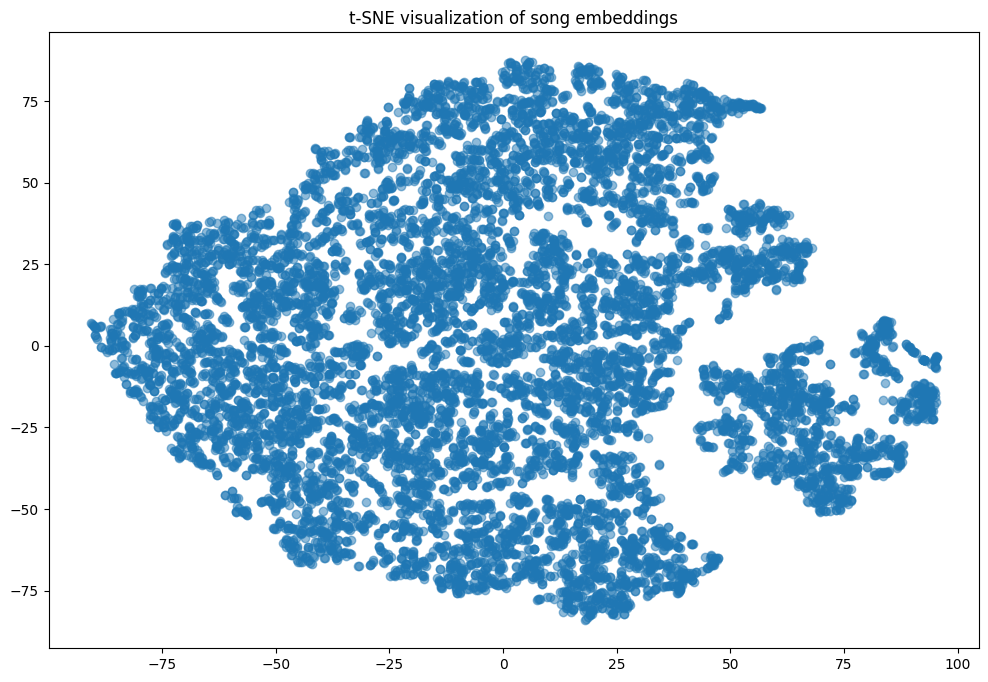

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(song_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)
plt.title("t-SNE visualization of song embeddings")
plt.show()

In [25]:
loss = autoencoder.evaluate(X_scaled, X_scaled)
print(f"Autoencoder reconstruction loss: {loss:.4f}")

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 2.0348e-04
Autoencoder reconstruction loss: 0.0002


In [26]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(song_embeddings)

score = silhouette_score(song_embeddings, labels)
print(f"Silhouette score: {score:.4f}")

Silhouette score: 0.1871


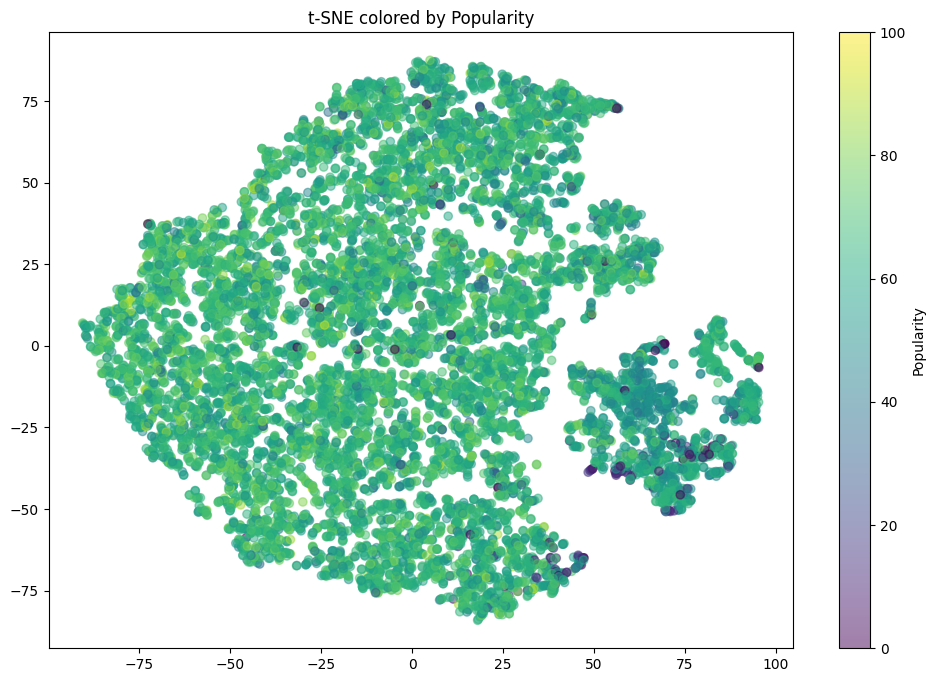

In [27]:
colors = pd.to_numeric(df['popularity'], errors='coerce')  # converts strings to numbers
plt.figure(figsize=(12, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, cmap='viridis', alpha=0.5)
plt.title("t-SNE colored by Popularity")
plt.colorbar(label='Popularity')
plt.show()

In [28]:
df['description'] = (
    df['name'] + ' by ' + df['updated_artists'].apply(lambda x: ', '.join(x)) +
    '. Energetic: ' + df['energy'].round(2).astype(str) +
    ', Danceable: ' + df['danceability'].round(2).astype(str) +
    ', Mood: ' + df['valence'].round(2).astype(str)
)


In [29]:
!pip install sentence_transformers
!pip install tf-keras
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight, effective

song_embeddings = model.encode(df['description'].tolist(), show_progress_bar=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 24.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.0 MB/s eta 0:00:00a 0:00:01


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Batches: 100%|██████████| 369/369 [03:53<00:00,  1.58it/s]


In [30]:
def recommend_by_prompt(prompt, top_n=5):
    query_embedding = model.encode([prompt])[0]
    sims = cosine_similarity([query_embedding], song_embeddings)[0]
    top_indices = sims.argsort()[::-1][:top_n]
    return df.iloc[top_indices][['name', 'updated_artists', 'album.name']]

In [ ]:
# recommend_by_prompt("happy upbeat party song", top_n=5)
# # recommend_by_prompt("something mellow and sad", top_n=5)
# # recommend_by_prompt("romantic slow dance", top_n=5)
# recommend_by_prompt("Indian sad song", top_n=5)
recommend_by_prompt("Indian happy  song", top_n=5)

,name,updated_artists,album.name
8569,Be Happy - Remix,"[3DKkhRCGOG4e8IUPYFPfWs, 2cFrymmkijnjDg9SS92EP...",Be Happy (Remix)
3101,"Dil Diyan Gallan (From ""Tiger Zinda Hai"")","[2oSONSC9zQ4UonDKnLqksx, Atif Aslam]",YRF Top 10 - Rewind
6993,Happy Does,"[3grHWM9bx2E9vwJCdlRv9O, Kenny Chesney]",Here And Now
3681,Be Happy,"[3DKkhRCGOG4e8IUPYFPfWs, Dixie DâAmelio, 3DK...",Be Happy
2546,Aye Dekhe Jaa,"[4YRxDV8wJFPHPTeXepOstw, Arijit Singh]",Top 20 of 2020


In [32]:
prompt = "Indian sad song"  # or any test phrase

In [33]:
query_embedding = model.encode([prompt])[0]
sims = cosine_similarity([query_embedding], song_embeddings)[0]

In [34]:
country_bias = 0.15  # Strength of boost; tune as needed
bias = df['IN'] * country_bias  # 1 if in India, else 0
biased_scores = sims + bias

In [35]:
top_n = 5  # or however many results you want
top_indices = biased_scores.argsort()[::-1][:top_n]
results = df.iloc[top_indices][['name', 'updated_artists', 'album.name', 'description']]

In [36]:
def recommend_biased_by_country(prompt, country_code='IN', country_boost=0.15, top_n=5):
    query_embedding = model.encode([prompt])[0]
    sims = cosine_similarity([query_embedding], song_embeddings)[0]

    # Add country bias softly
    bias = df[country_code] * country_boost
    biased_scores = sims + bias

    top_indices = biased_scores.argsort()[::-1][:top_n]
    return df.iloc[top_indices][['name', 'updated_artists', 'album.name', 'description']]

In [37]:
recommend_biased_by_country("Arijit Singh", country_code='IN', country_boost=0.9, top_n=5)

,name,updated_artists,album.name,description
2546,Aye Dekhe Jaa,"[4YRxDV8wJFPHPTeXepOstw, Arijit Singh]",Top 20 of 2020,"Aye Dekhe Jaa by 4YRxDV8wJFPHPTeXepOstw, Ariji..."
18118,Ore Mon Udashi,"[4YRxDV8wJFPHPTeXepOstw, Arijit Singh]",Bangla Emotional Hits,"Ore Mon Udashi by 4YRxDV8wJFPHPTeXepOstw, Arij..."
9768,Abar Phire Ele,"[4YRxDV8wJFPHPTeXepOstw, Arijit Singh]",Top 20 of 2020,"Abar Phire Ele by 4YRxDV8wJFPHPTeXepOstw, Arij..."
10609,Zaalima,"[4YRxDV8wJFPHPTeXepOstw, 3xU8YsNNkmWSPewlB18NU...",Raees,"Zaalima by 4YRxDV8wJFPHPTeXepOstw, 3xU8YsNNkmW..."
16273,Chantaje (feat. Maluma),"[0EmeFodog0BfCgMzAIvKQp, 1r4hJ1h58CWwUQe3MxPua...",El Dorado,Chantaje (feat. Maluma) by 0EmeFodog0BfCgMzAIv...


In [38]:
%pip install langdetect

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 4.8 MB/s eta 0:00:00m-:--:--
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993284 sha256=23f13999adca943e6f0bce81ca373dcaf27ca9b9943fa8388ea6d6bffd092332
  Stored in directory: /home/codespace/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [39]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0  # Make results consistent

In [40]:
language_to_country = {
    'hi': 'IN',
    'pa': 'IN',
    'ta': 'IN',
    'te': 'IN',
    'en': 'US',
    'es': 'ES',
    'fr': 'FR',
    'de': 'DE',
    'ja': 'JP',
    'ko': 'KR'
}

In [41]:
def detect_language(title):
    try:
        return detect(title)
    except:
        return 'unknown'

df['detected_language'] = df['name'].apply(detect_language)
df['country_code'] = df['detected_language'].apply(lambda lang: language_to_country.get(lang, 'IN'))  # fallback: IN

In [42]:
df['description'] = (
    df['name'] + ' by ' + df['updated_artists'].apply(lambda x: ', '.join(x)) +
    '. Language: ' + df['detected_language'] +
    '. Energy: ' + df['energy'].round(2).astype(str) +
    ', Danceability: ' + df['danceability'].round(2).astype(str) +
    ', Valence: ' + df['valence'].round(2).astype(str)
)

In [43]:
model = SentenceTransformer('all-MiniLM-L6-v2')
song_embeddings = model.encode(df['description'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 369/369 [03:58<00:00,  1.54it/s]


In [44]:
def smart_recommend(prompt, country_boost=0.2, top_n=5):
    query_embedding = model.encode([prompt])[0]
    sims = cosine_similarity([query_embedding], song_embeddings)[0]

    # Detect country from prompt
    try:
        prompt_lang = detect(prompt)
    except:
        prompt_lang = 'unknown'

    prompt_country = language_to_country.get(prompt_lang, 'IN')

    # Apply bias using country column
    bias = df[prompt_country] * country_boost if prompt_country in df.columns else 0
    biased_scores = sims + bias

    top_indices = biased_scores.argsort()[::-1][:top_n]
    return df.iloc[top_indices][['name', 'updated_artists', 'album.name', 'description', 'detected_language']]

In [45]:
smart_recommend("happy hindi song Atif Aslam")

,name,updated_artists,album.name,description,detected_language
3101,"Dil Diyan Gallan (From ""Tiger Zinda Hai"")","[2oSONSC9zQ4UonDKnLqksx, Atif Aslam]",YRF Top 10 - Rewind,"Dil Diyan Gallan (From ""Tiger Zinda Hai"") by 2...",tr
16975,Ruler Rebel (X. aTunde Adjuah Remix),"[2q37Nw8NND2z1T1KU5XVfn, Christian Scott aTund...",The Emancipation Procrastination,Ruler Rebel (X. aTunde Adjuah Remix) by 2q37Nw...,de
2546,Aye Dekhe Jaa,"[4YRxDV8wJFPHPTeXepOstw, Arijit Singh]",Top 20 of 2020,"Aye Dekhe Jaa by 4YRxDV8wJFPHPTeXepOstw, Ariji...",so
18979,DÃ©solÃ© (feat. Fatoumata Diawara) - Extended ...,"[3AA28KZvwAUcZuOKwyblJQ, 4G5ZJny3HvX6Il7eHVfnN...","Song Machine, Season One: Strange Timez (Deluxe)",DÃ©solÃ© (feat. Fatoumata Diawara) - Extended ...,en
4024,"Thanmaya Naanu (From ""Zamana"")","[70B80Lwx2sxti0M1Ng9e8K, 0gGWvTJmHll6hwscYp0pn...",Voice Of Udit Narayan Birthday Special Kannada...,"Thanmaya Naanu (From ""Zamana"") by 70B80Lwx2sxt...",tl


In [46]:
smart_recommend("Punjabi party track")


,name,updated_artists,album.name,description,detected_language
5651,Grove St. Party (feat. Kebo Gotti),"[6f4XkbvYlXMH0QgVRzW0sM, 00UOluVoYY4F2blO5DmgR...",Flockaveli,Grove St. Party (feat. Kebo Gotti) by 6f4XkbvY...,en
17069,Bangarang (feat. Sirah),"[5he5w2lnU9x7JFhnwcekXX, 3oAazIwC0nAYkOKVQPUC3...",Bangarang EP,Bangarang (feat. Sirah) by 5he5w2lnU9x7JFhnwce...,id
17517,"Numbers (feat. Roddy Ricch, Gunna and London O...","[31W5EY0aAly4Qieq6OFu6I, 5Nf5yishRW9Ye174sJISk...",Artist 2.0,"Numbers (feat. Roddy Ricch, Gunna and London O...",en
3639,Party (feat. Usher & Gucci Mane),"[7bXgB6jMjp9ATFy66eO08Z, 23zg3TcAtWQy7J6upgbUn...",Heartbreak on a Full Moon,Party (feat. Usher & Gucci Mane) by 7bXgB6jMjp...,en
2546,Aye Dekhe Jaa,"[4YRxDV8wJFPHPTeXepOstw, Arijit Singh]",Top 20 of 2020,"Aye Dekhe Jaa by 4YRxDV8wJFPHPTeXepOstw, Ariji...",so


In [47]:
!pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 3.6 MB/s eta 0:00:00-:--:--


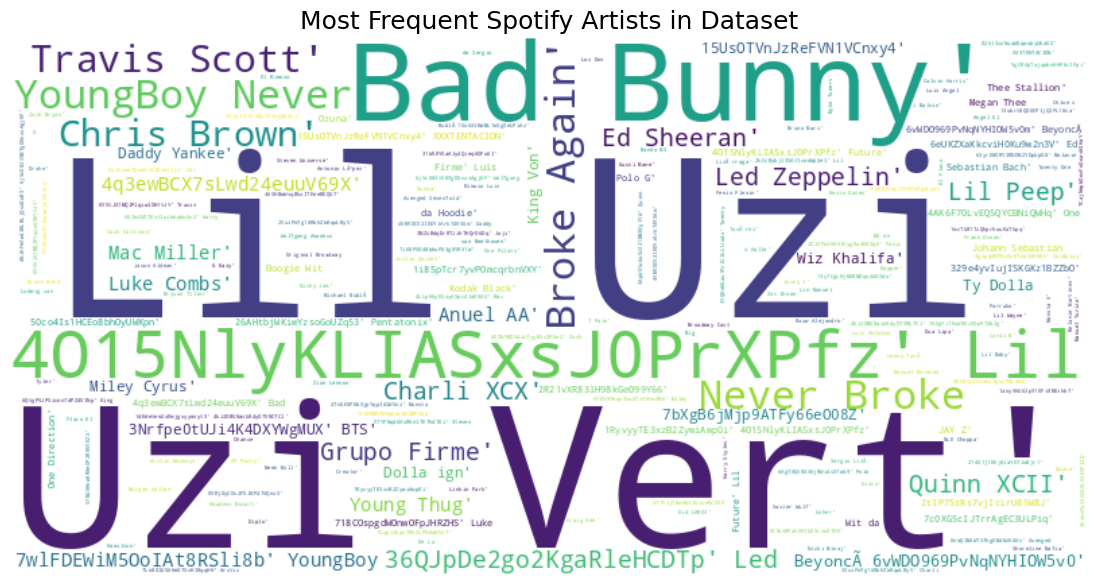

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all artist names into a single string
text = " ".join(artist for artist in df["updated_artists"].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Spotify Artists in Dataset", fontsize=18)
plt.show()

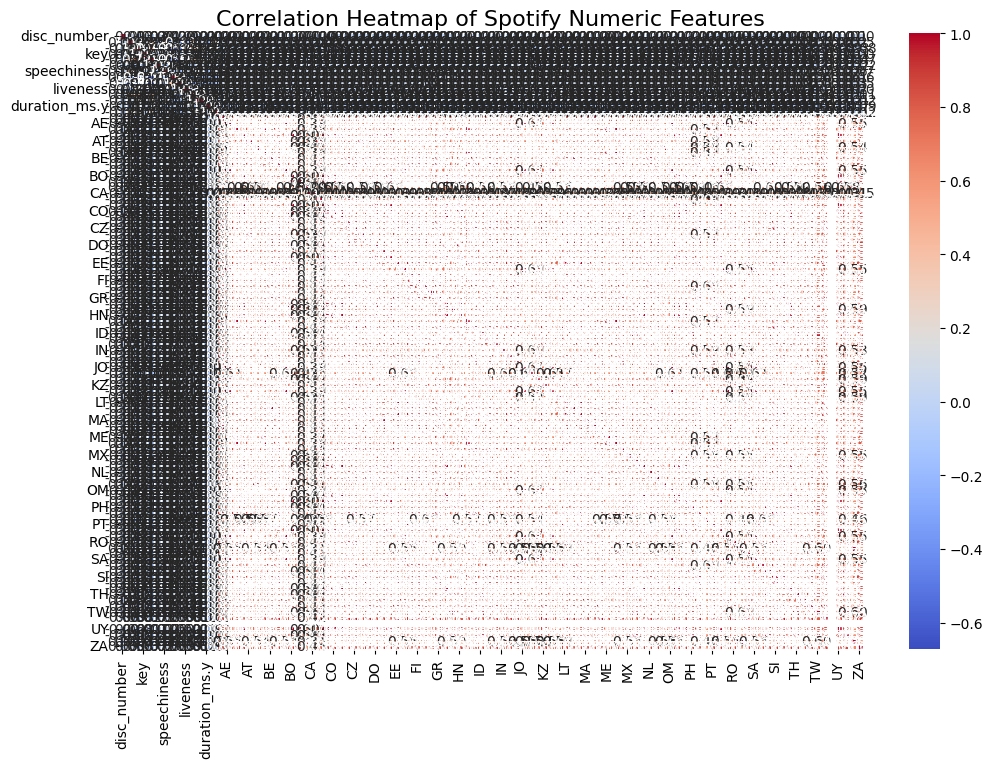

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Spotify Numeric Features", fontsize=16)
plt.show()

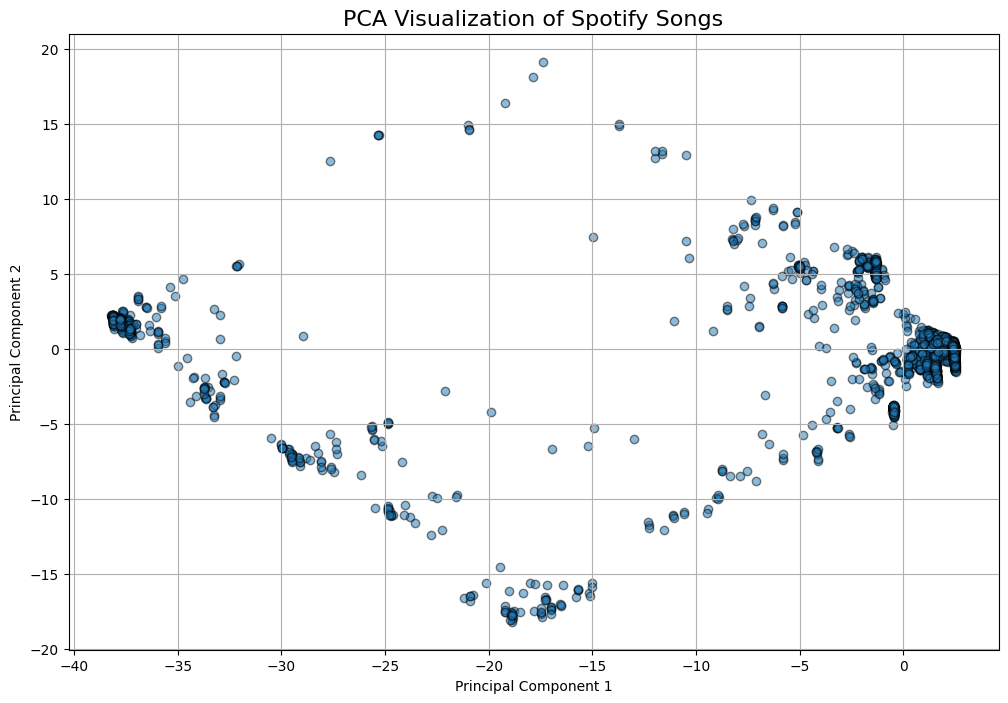

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select numeric features and standardize them
features = df.select_dtypes(include=['float64', 'int64'])
scaled_features = StandardScaler().fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Add PCA results to the dataframe
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Plot the PCA result
plt.figure(figsize=(12, 8))
plt.scatter(df['PCA1'], df['PCA2'], alpha=0.5, edgecolors='k')
plt.title('PCA Visualization of Spotify Songs', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

/tmp/ipykernel_8809/4029094045.py:9: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


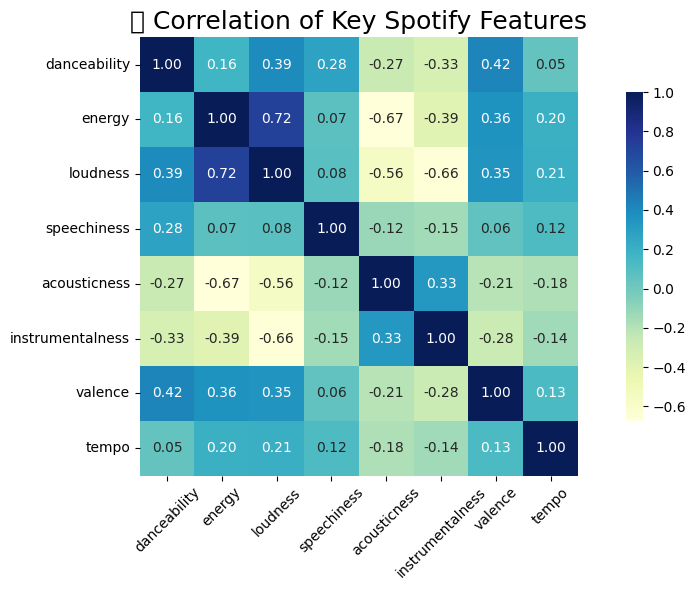

In [51]:
selected_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
corr = df[selected_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt=".2f", square=True, cbar_kws={"shrink": 0.75})
plt.title("🎧 Correlation of Key Spotify Features", fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_8809/3435433295.py:7: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


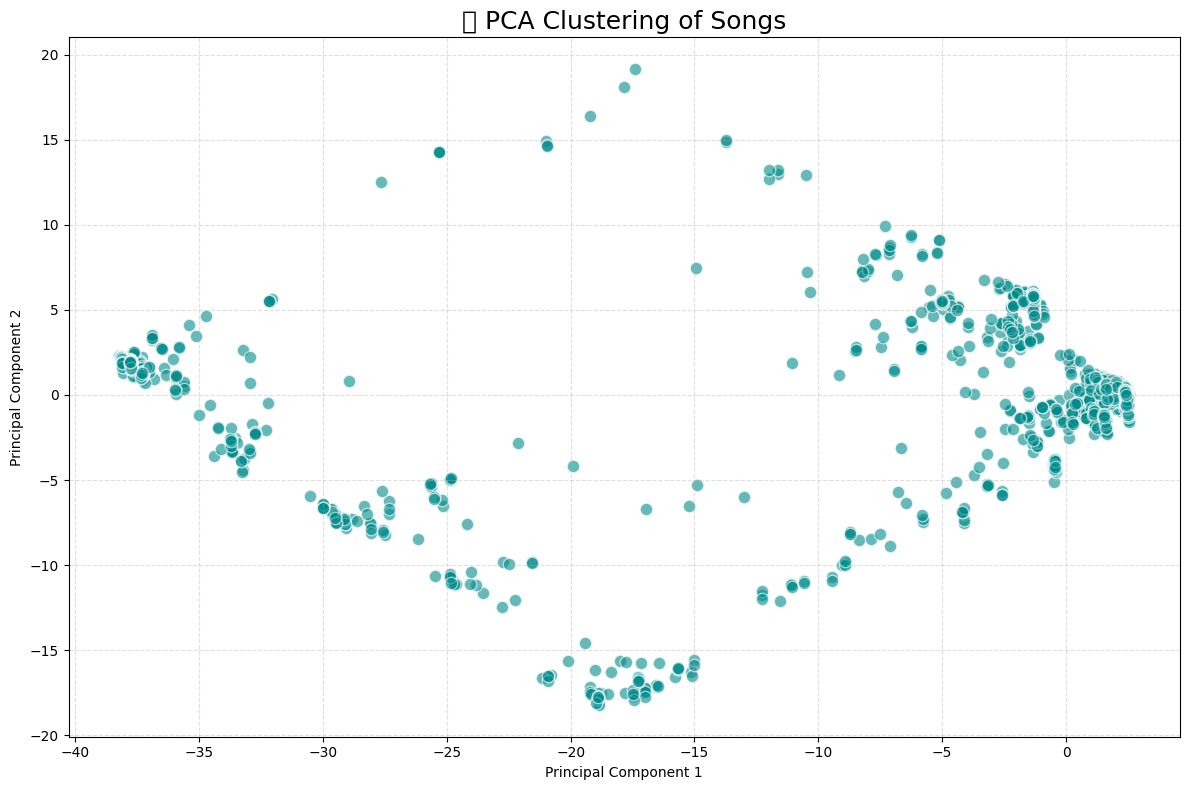

In [52]:
plt.figure(figsize=(12, 8))
plt.scatter(df['PCA1'], df['PCA2'], alpha=0.6, c='darkcyan', edgecolors='w', s=80)
plt.title("🌀 PCA Clustering of Songs", fontsize=18)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()